# Color-DCT image compression

Removing redundancy in the color domain with the DCT, that is an orthonormal (ortongonal + unitary) and energy preserving transform.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
!ln -sf ~/quantization/deadzone_quantizer.py .
!ln -sf ~/quantization/midtread_quantizer.py .
!ln -sf ~/quantization/midrise_quantizer.py .
!ln -sf ~/quantization/distortion.py .
!ln -sf ~/quantization/information.py .
!ln -sf ~/MRVC/src/YCrCb.py .
!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/image_3.py .
!ln -sf ~/MRVC/src/image_1.py .
!ln -sf ../common.py .
import deadzone_quantizer as deadzone
import midtread_quantizer as midtread
import midrise_quantizer as midrise
import YCrCb
import distortion
import information
import image_3 as RGB_image
import image_1 as gray_image
import colored
import common

## Configuration

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
fn = home + "/MRVC/sequences/lena_color/"
#fn = home + "/MRVC/sequences/stockholm/"
image_dtype = np.uint8

DCT_components = ['0', '1', '2']

# Number of quantization steps.
N_Q_steps = 8
#Q_steps = [256*i/N_Q_steps for i in range(N_Q_steps + 1, 0, -1)]
Q_steps = [2**i for i in range(7, -1, -1)]
print(Q_steps)

#quantizer = midtread
quantizer = deadzone
#quantizer = midrise

[128, 64, 32, 16, 8, 4, 2, 1]


## Read the image and show it

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 


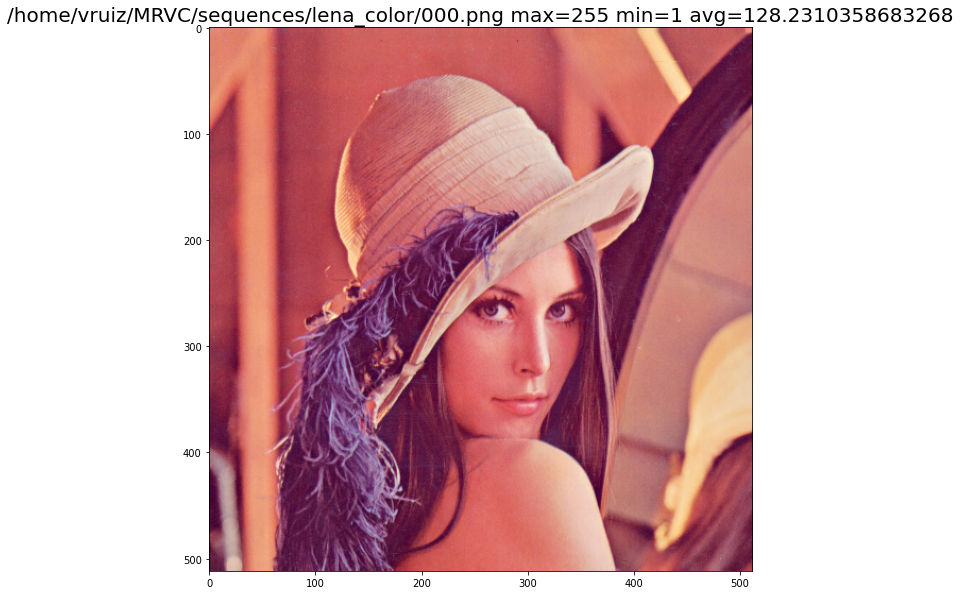

In [3]:
RGB_img = RGB_image.read(fn).astype(image_dtype)
common.show(RGB_img, fn + "000.png")

In [4]:
RGB_img.shape

(512, 512, 3)

In [5]:
RGB_img.dtype

dtype('uint8')

## (RGB -> ColorDCT) transform of the image

In [18]:
import numpy as np
from scipy.fftpack import dct, idct

DCT_type = 3
norm = "ortho" # Orthonormal: orthogonal + unitary (unit gain in both directions of the transform)
#norm = None

In [19]:
def color_DCT(RGB_img):
    DCT_img = np.empty_like(RGB_img).astype(np.float)
    for y in range(RGB_img.shape[0]):
        for x in range(RGB_img.shape[1]):
            DCT_img[y, x] = dct(RGB_img[y, x], type=DCT_type, norm=norm)
    return DCT_img

def color_IDCT(DCT_img):
    RGB_img = np.empty_like(DCT_img).astype(image_dtype)
    for y in range(DCT_img.shape[0]):
        for x in range(DCT_img.shape[1]):
            RGB_img[y, x] = idct(DCT_img[y, x], type=DCT_type, norm=norm)
    return RGB_img

In [20]:
DCT_img = color_DCT(RGB_img)
print(DCT_img.dtype)

float64


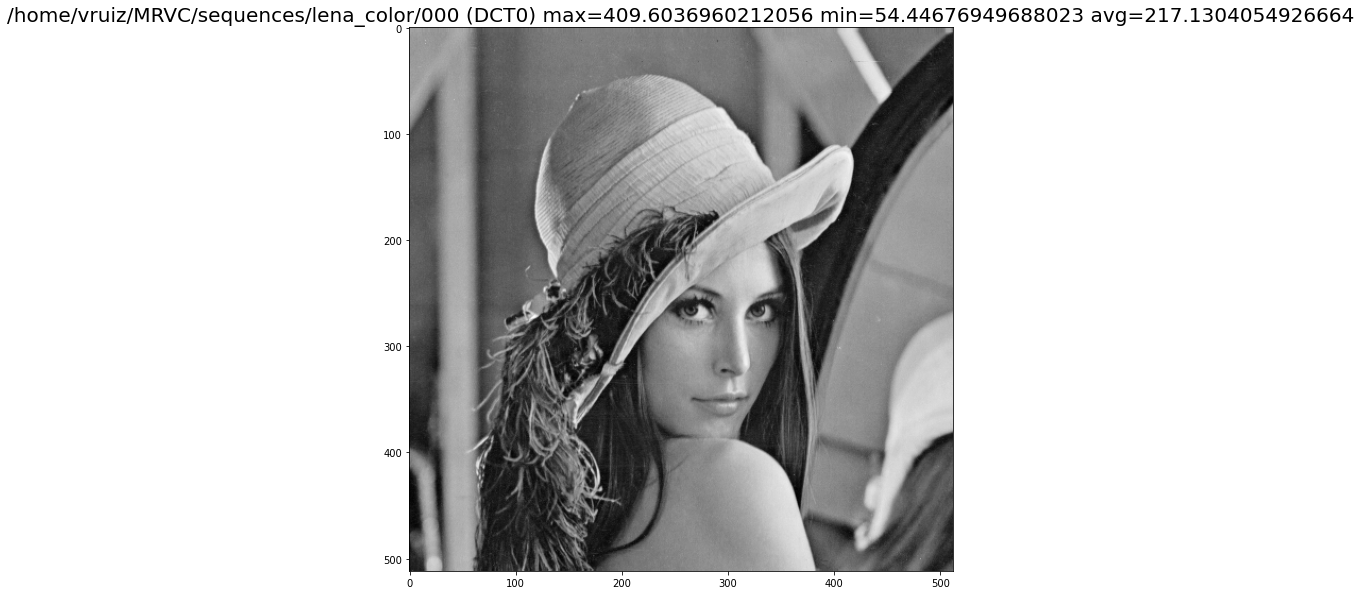

In [21]:
common.show_gray(DCT_img[..., 0], fn + "000 (DCT0)")

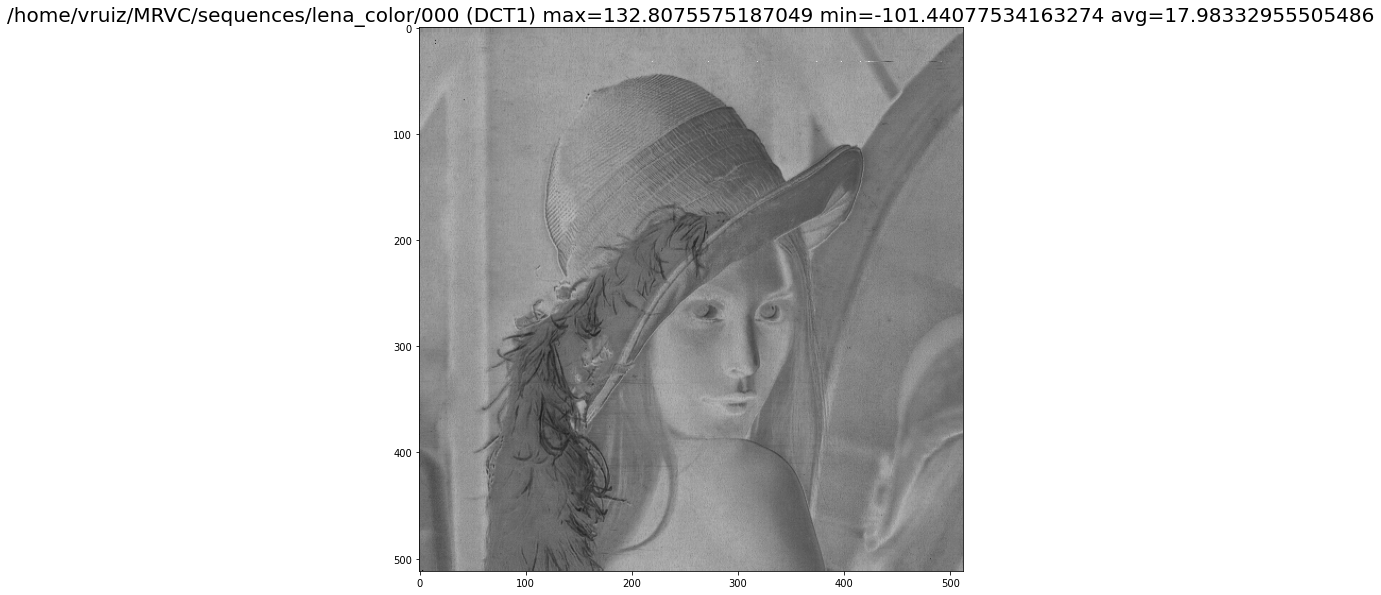

In [22]:
common.show_gray(DCT_img[..., 1], fn + "000 (DCT1)")

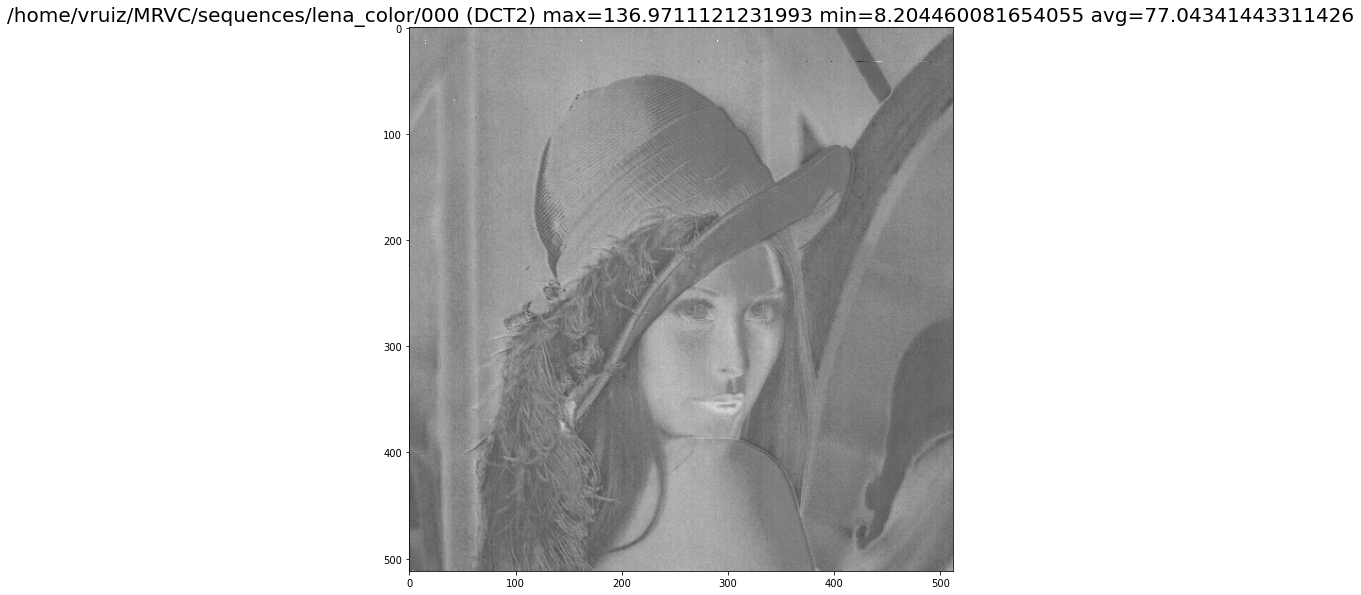

In [23]:
common.show_gray(DCT_img[..., 2], fn + "000 (DCT2)")

## Energy of the DCT components

In [24]:
DCT0_avg_energy = information.average_energy(DCT_img[..., 0])
DCT1_avg_energy = information.average_energy(DCT_img[..., 1])
DCT2_avg_energy = information.average_energy(DCT_img[..., 2])
print(f"Average energy DCT[..., 0] = {DCT0_avg_energy}")
print(f"Average energy DCT[..., 1] = {DCT1_avg_energy}")
print(f"Average energy DCT[..., 2] = {DCT2_avg_energy}")
total_DCT_avg_energy = DCT0_avg_energy + DCT1_avg_energy + DCT2_avg_energy
print(f"Total average energy (computed by adding the energies of the DCT coefficients) = {total_DCT_avg_energy}")
print(f"Total RGB average energy (computed directly from the RGB image) = {information.average_energy(RGB_img)*3}")

Average energy DCT[..., 0] = 52878.640538531785
Average energy DCT[..., 1] = 833.5140930158013
Average energy DCT[..., 2] = 6054.43547160184
Total average energy (computed by adding the energies of the DCT coefficients) = 59766.59010314943
Total RGB average energy (computed directly from the RGB image) = 59766.590103149414


Therefore, the forward DCT is almost energy preserving.

In [25]:
RGB_recons_img = color_IDCT(DCT_img)
print(f"Total RGB average energy (computed from the reconstructed RGB image) = {information.average_energy(RGB_recons_img)*3}")

Total RGB average energy (computed from the reconstructed RGB image) = 59753.392208099365


And the same can be said of the backward transform.

## (RGB <-> ColorDCT) transform error

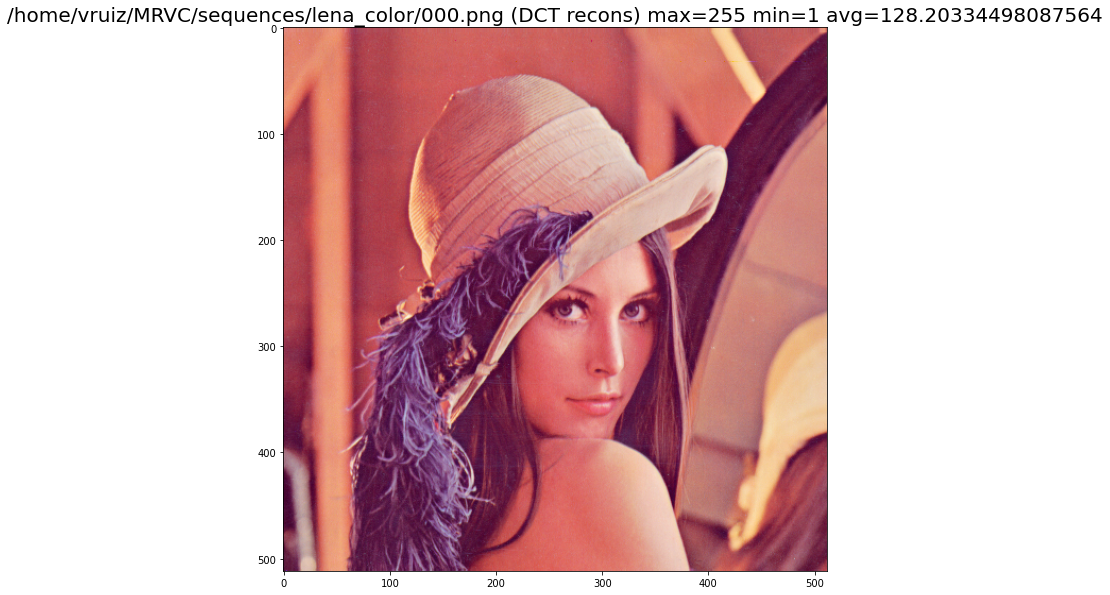

In [26]:
common.show(RGB_recons_img, fn + "000.png (DCT recons)")

In [27]:
#RGB_img2 = YCrCb.to_RGB(DCT_img)

In [28]:
np.array_equal(RGB_img, RGB_recons_img)

False

In [29]:
print(RGB_img.max(), RGB_img.min())

255 1


In [30]:
print(RGB_recons_img.max(), RGB_recons_img.min())

255 1


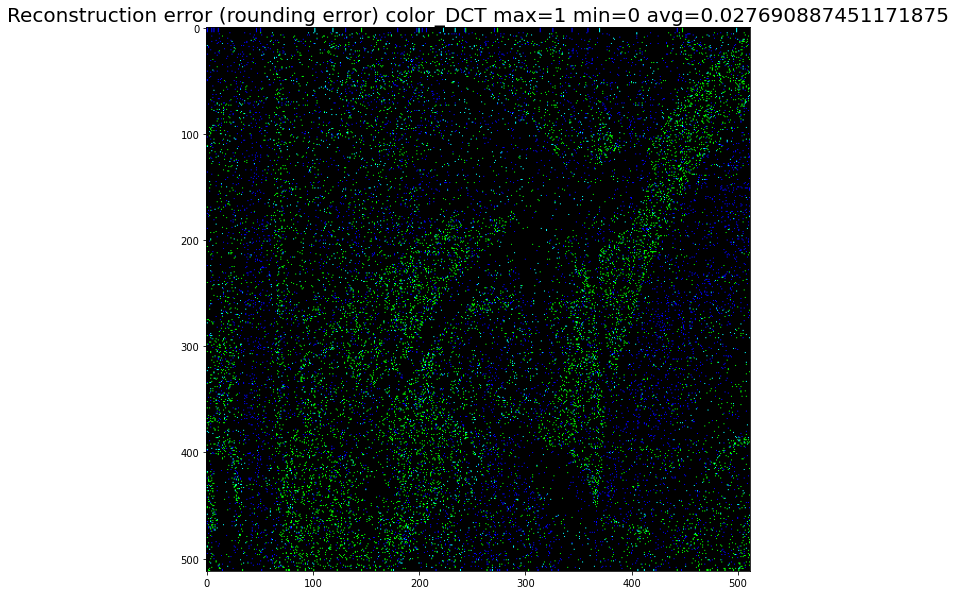

In [31]:
common.show(RGB_img-RGB_recons_img, "Reconstruction error (rounding error) color_DCT")

The DCT transform is irreversible. In general, only integer arithmetic operations guarantees reversibility.

## Synthesis filters gains

The synthesis filters gains are important because the quantization steps of each DCT component should be adjusted in order to effectively provide the desired number of [bins](http://www.winlab.rutgers.edu/~crose/322_html/quantization.pdf) (different dequantized values) in each component.

In [32]:
def print_info(val):
    DCT0_delta = np.array([val, 0, 0])
    RGB_DCT0_delta = idct(DCT0_delta, type=DCT_type, norm=norm)
    RGB_energy_DCT0_delta = information.energy(RGB_DCT0_delta)
    
    DCT1_delta = np.array([0, val, 0])
    RGB_DCT1_delta = idct(DCT1_delta, type=DCT_type, norm=norm)
    RGB_energy_DCT1_delta = information.energy(RGB_DCT1_delta)
    
    DCT2_delta = np.array([0, 0, val])
    RGB_DCT2_delta = idct(DCT2_delta, type=DCT_type, norm=norm)
    RGB_energy_DCT2_delta = information.energy(RGB_DCT2_delta)
    
    zero = np.array([0, 0, 0])
    RGB_zero = idct(zero, type=DCT_type, norm=norm)
    RGB_energy_zero = information.energy(RGB_zero)
    
    print(f"Energy of {DCT0_delta} in the RGB domain ({RGB_DCT0_delta}) = {RGB_energy_DCT0_delta}")
    print(f"Energy of {DCT1_delta} in the RGB domain ({RGB_DCT1_delta}) = {RGB_energy_DCT1_delta}")
    print(f"Energy of {DCT2_delta} in the RGB domain ({RGB_DCT2_delta}) = {RGB_energy_DCT2_delta}")
    print(f"Energy of {zero} in the RGB domain ({RGB_zero}) = {RGB_energy_zero}")
    
    max_ = max(RGB_energy_DCT0_delta, RGB_energy_DCT1_delta, RGB_energy_DCT2_delta)
    DCT0_relative_gain = RGB_energy_DCT0_delta / max_
    DCT1_relative_gain = RGB_energy_DCT1_delta / max_
    DCT2_relative_gain = RGB_energy_DCT2_delta / max_
    print(f"Relative gain of DCT0 component = {DCT0_relative_gain}")
    print(f"Relative gain of DCT1 component = {DCT1_relative_gain}")
    print(f"Relative gain of DCT2 component = {DCT2_relative_gain}")
    
print_info(255)
print()
print_info(1)
print()
print_info(0)

Energy of [255   0   0] in the RGB domain ([147.22431864 180.3122292  104.10331407]) = 65025.000000000015
Energy of [  0 255   0] in the RGB domain ([ 147.22431864    0.         -208.20662814]) = 65025.00000000001
Energy of [  0   0 255] in the RGB domain ([ 147.22431864 -180.3122292   104.10331407]) = 65025.000000000015
Energy of [0 0 0] in the RGB domain ([0. 0. 0.]) = 0.0
Relative gain of DCT0 component = 1.0
Relative gain of DCT1 component = 0.9999999999999999
Relative gain of DCT2 component = 1.0

Energy of [1 0 0] in the RGB domain ([0.57735027 0.70710678 0.40824829]) = 1.0000000000000002
Energy of [0 1 0] in the RGB domain ([ 0.57735027  0.         -0.81649658]) = 1.0
Energy of [0 0 1] in the RGB domain ([ 0.57735027 -0.70710678  0.40824829]) = 1.0000000000000002
Energy of [0 0 0] in the RGB domain ([0. 0. 0.]) = 0.0
Relative gain of DCT0 component = 1.0
Relative gain of DCT1 component = 0.9999999999999998
Relative gain of DCT2 component = 1.0

Energy of [0 0 0] in the RGB domai

<ipython-input-32-a6044ddc8c9a>:24: RuntimeWarning: invalid value encountered in double_scalars
  DCT0_relative_gain = RGB_energy_DCT0_delta / max_
<ipython-input-32-a6044ddc8c9a>:25: RuntimeWarning: invalid value encountered in double_scalars
  DCT1_relative_gain = RGB_energy_DCT1_delta / max_
<ipython-input-32-a6044ddc8c9a>:26: RuntimeWarning: invalid value encountered in double_scalars
  DCT2_relative_gain = RGB_energy_DCT2_delta / max_


The gain of each DCT inverse filter is 1. Therefore, the optimal quantization pattern is $\Delta_{\text{DCT0}} = \Delta_{\text{DCT1}} = \Delta_{\text{DCT2}}$.

## Noise in the DCT domain

To decide how to quantize, it is necessary to known how the amplitudes the electronic noise of the input image is transformed to the DCT domain. To see this, we will generate a random image with ([normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)) [Gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noise) with mean 0, DCT-it, and check where the transformed noise has its mean. Notice that, by definition, the noise cannot be decorrelated by transforms, and therefore, the noise is simply transfered to the transform domain.

In [35]:
# loc = mean, scale=standard deviation, size=number of samples
RGB_noise = np.random.normal(loc=0, scale=10, size=512*512*3).reshape(512,512,3).astype(image_dtype)

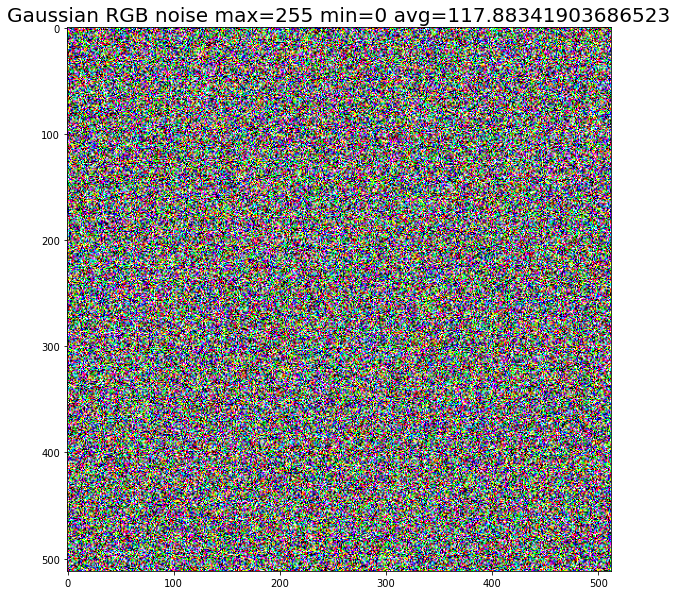

In [36]:
common.show(RGB_noise, "Gaussian RGB noise")

In [37]:
DCT_noise = dct(RGB_noise, type=DCT_type, norm=norm)

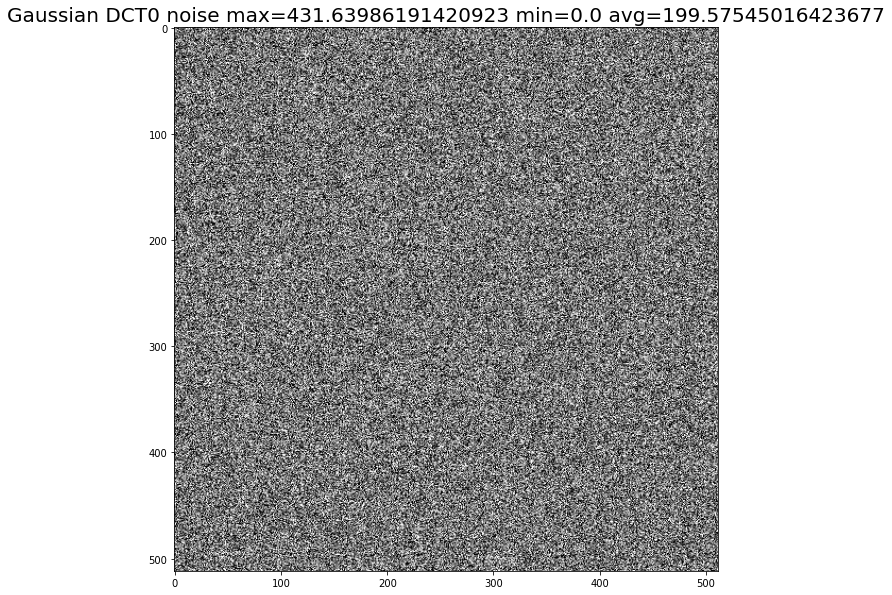

In [38]:
common.show_gray(DCT_noise[..., 0], "Gaussian DCT0 noise")

In [ ]:
common.show_gray(DCT_noise[..., 1], "Gaussian DCT1 noise")

In [ ]:
common.show_gray(DCT_noise[..., 2], "Gaussign DCT2 noise")

The DCT does not modify the mean of the signal when it has 0 mean. Therefore, the electronic noise (that is white, i.e., have energy in all the amplitudes and frequencies) that produces the smallest [SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) when the amplitude of the input image is also small (less signal, same noise), will be more attenuated by a dead-zone quantizer, when the mean of the signal to quantize is also 0. In other words, the input signal to a dead-zone quantizer must have 0 mean.

## Simple quantization in the DCT domain ($\Delta_{\text{DCT0}} = \Delta_{\text{DCT1}} = \Delta_{\text{DCT2}}$)
Notice that, because the transform is orthogonal, the distortion can be measured in both, the RGB and the DCT domains. In the following cell, for efficiency, the quantizaton error is measured in the transform domain.

In [ ]:
def DCT_same_delta_RD_curve(RGB_img, Q_steps, quantizer):
    DCT_img = color_DCT(RGB_img)#.astype(np.int16)
    points = []
    for Q_step in Q_steps:
        y_DCT, k = quantizer.quan_dequan(DCT_img, Q_step)
        k_min = np.min(k)
        rate = common.bits_per_color_pixel((k - k_min).astype(np.uint8), str(Q_step) + '_')
        #y_RGB = inverse_color_IDCT(y_DCT)            # Uncomment these lines for measuring
        #_distortion = distortion.MSE(RGB_img, y_RGB) # the distortion in the RGB domain.
        _distortion = distortion.MSE(DCT_img, y_DCT) # Uncomment this line for measuring the distortion in the DCT domain
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

DCT_same_delta_RD_points = DCT_same_delta_RD_curve(RGB_img, Q_steps, quantizer)

## Let's see the RD curve

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_same_delta_RD_points), c='g', marker='.', label="$\Delta_{\mathrm{DCT0}} = \Delta_{\mathrm{DCT1}} = \Delta_{\mathrm{DCT2}}$", linestyle="dashed")
pylab.title("Rate/Distortion")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## Optimal RD curve

The method `DCT_same_delta_RD_curve(img, Q_steps, quantizer)` generates a RD curve where each point is the result of using $\Delta_{\text{DCT0}} = \Delta_{\text{DCT1}} = \Delta_{\text{DCT2}}$. However, a better (at least with more points) RD curve can be generated with:

1. Convert the image from RGB to DCT{0,1,2}.
2. The RD curve of each DCT channel is computed, for a number of quantization steps, measuring the distortion in the RGB domain. We will quantize one component at each iteration and the rest of components will be unquantized. This is necessary to ensure that the low-pass component (DCT0) is always considered in each reconstruction. Otherwise, the distortion (at least using the MSE) will not be estimated correctly.
3. Compute the slope of each segment of the RD curve. Except for the most left point, the slopes are computed as the average between the slopes of the straight lines that connect to the corresponding point.
4. For each quantization step, sort the RD points by their slope.
5. Recompute the optimal RD curve using the quantization steps provided by the sorted RD points.

## RD curve of each DCT component

In [ ]:
def color_DCT_RD_curve_per_component(RGB_img, Q_steps, Q, components):
    DCT_img = color_DCT(RGB_img)
    DCT_img_copy = DCT_img.copy()
    N_components = len(components)
    RD_points = []
    for c in range(N_components):
        RD_points.append([])
    for Q_step in Q_steps:
        DCT_k = Q.quantize(DCT_img, Q_step)
        for component_index in range(N_components):
            k_min = np.min(DCT_k[..., component_index])
            component_name = components[component_index]
            DCT_y = np.zeros_like(DCT_img)
            DCT_y = DCT_img_copy.copy()
            DCT_y[..., component_index] = Q.dequantize(DCT_k[..., component_index], Q_step)
            #print(Q_step, DCT_k[..., component_index].max(), DCT_k[..., component_index].min(), information.entropy(DCT_k[..., component_index]))
            rate = common.bits_per_gray_pixel(DCT_k[..., component_index] - k_min, str(Q_step) + '_' + component_name + '_' + str(components[component_index]))
            RGB_y = color_IDCT(DCT_y)
            _distortion = distortion.MSE(RGB_img, RGB_y)
            #common.show(RGB_y, components[component_index] + ' ' + str(Q_step))
            RD_points[component_index].append((rate, _distortion, component_name, Q_step))
            print(f"{np.min(DCT_k[..., component_index] - k_min)} {components[component_index]} q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points
           
DCT_curve_per_component = color_DCT_RD_curve_per_component(RGB_img, Q_steps, quantizer, DCT_components)
DCT_curve_per_component

## Display the curves of the components

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT_curve_per_component[0]]), c='r', marker='.', label="$\mathrm{DCT0}}$", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT_curve_per_component[1]]), c='g', marker='.', label="$\mathrm{DCT1}}$", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT_curve_per_component[2]]), c='b', marker='.', label="$\mathrm{DCT2}}$", linestyle="dashed")
pylab.title("Rate/Distortion")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## Compute the slope of each point

In [ ]:
def compute_slope(left_BPP, left_MSE, right_BPP, right_MSE):
    delta_BPP = right_BPP - left_BPP
    delta_MSE = left_MSE - right_MSE
    if delta_BPP > 0:
        slope = delta_MSE / delta_BPP
    else:
        slope = 0
    return slope

def compute_slopes(RD_points):
    counter = 0
    _RD_slopes = []
    points_iterator = iter(RD_points)
    left = next(points_iterator)
    left_BPP = left[0]
    left_MSE = left[1]
    right = next(points_iterator)
    right_BPP = right[0]
    right_MSE = right[1]
    slope = compute_slope(left_BPP, left_MSE, right_BPP, right_MSE)
    _RD_slopes.append((slope, left[2], left[3]))
    _RD_slopes.append((slope, right[2], right[3]))
    left = right
    for right in points_iterator:
        right_BPP = right[0]
        right_MSE = right[1]
        #print(RD_points[counter])
        slope = compute_slope(left_BPP, left_MSE, right_BPP, right_MSE)
        _RD_slopes.append((slope, right[2], right[3]))
        counter += 1
        left = right
        left_BPP = left[0]
        left_MSE = left[1]
        #left_BPP = right_BPP
        #left_MSE = right_MSE
    RD_slopes = []
    slopes_iterator = iter(_RD_slopes)
    left = next(slopes_iterator)
    #print("-->",_RD_slopes)
    #return _RD_slopes
    #RD_slopes.append(left)
    #print(left)
    for right in slopes_iterator:
        #print(left, right)
        RD_slopes.append((((left[0] + right[0])/2), right[1], left[2]))
        left = right
    RD_slopes.append(right)
    return RD_slopes

#print("(Slope (rate, distortion, component, Q_step)) delta_MSE delta_BPP:\n")
DCT0_slopes = common.compute_slopes(DCT_curve_per_component[0])
DCT1_slopes = common.compute_slopes(DCT_curve_per_component[1])
DCT2_slopes = common.compute_slopes(DCT_curve_per_component[2])

In [ ]:
DCT0_slopes

In [ ]:
DCT1_slopes

In [ ]:
DCT2_slopes

## Filter the curves
Remove those RD points that do not belong to the convex-hull

In [ ]:
def filter_slopes(slopes):
    filtered_slopes = []
    slopes_iterator = iter(slopes)
    prev = next(slopes_iterator)
    for curr in slopes_iterator:
        if prev[0] < curr[0]:
            print(f"deleted {prev}")
        else:
            filtered_slopes.append(prev)
        prev = curr
    filtered_slopes.append(prev)
    return filtered_slopes

In [ ]:
DCT0_slopes = common.filter_slopes(DCT0_slopes)
DCT0_slopes

In [ ]:
DCT1_slopes = filter_slopes(DCT1_slopes)
DCT1_slopes

In [ ]:
DCT2_slopes = filter_slopes(DCT2_slopes)
DCT2_slopes

## Sort the slopes at each quantization step
Notice that the TPs (Truncation Points) generated in a component must be used in order.

In [ ]:
all_slopes = DCT0_slopes + DCT1_slopes + DCT2_slopes
sorted_slopes = sorted(all_slopes, key=lambda x: x[0])[::-1]
sorted_slopes

## Compute the optimal RD curve
And finally, let's compute the RD curve (remember that the previous points are only an estimation of the order in which the quantization steps should be increased in each component to build the RD curve, not the real RD curve that measures the distortion in the RGB domain).

In [ ]:
def DCT_optimal_curve(RGB_img, sorted_slopes, quantizer, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    DCT_img = color_DCT(RGB_img)
    k = np.empty_like(DCT_img)
    DCT_y = np.empty_like(DCT_img)
    for i in sorted_slopes:
        print(i)
        component, Q_step = i[1], i[2]
        Q_steps_per_component[components.index(component)] = Q_step
        for c, Q_step in zip(components, Q_steps_per_component):
            component_index = components.index(c)
            DCT_y[..., component_index], k[..., component_index] = quantizer.quan_dequan(DCT_img[..., component_index], Q_step)
        k_min = np.min(k[..., component_index])
        k = (k - k_min).astype(np.uint8)
        rate = common.bits_per_color_pixel(k, str(Q_steps_per_component) + '_')
        #y_RGB = YCrCb.to_RGB(y + 128)
        #RGB_y = color_IDCT(DCT_y)                     # Uncomment to compute distortion
        #_distortion = distortion.MSE(RGB_img, RGB_y)  # in the RGB domain.
        _distortion = distortion.MSE(DCT_img, DCT_y)  # Uncomment to compute distortion in the DCT domain.
        #common.show(y_RGB, f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

DCT_optimal_RD_points = DCT_optimal_curve(RGB_img, sorted_slopes, quantizer, DCT_components)
DCT_optimal_RD_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_same_delta_RD_points), c='b', marker='o', label="$\Delta_{\mathrm{DCT0}} = \Delta_{\mathrm{DCT1}} = \Delta_{\mathrm{DCT2}}$", linestyle="dashed")
pylab.plot(*zip(*DCT_optimal_RD_points), c='r', marker='x', label="Optimal", linestyle="dotted")
pylab.title("Rate/Distortion")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## Conclusión
The performance of the simple quantization solution ($\Delta_{\mathrm{DCT0}} = \Delta_{\mathrm{DCT1}} = \Delta_{\mathrm{DCT2}}$) is very close to the optimal one.